Text(0.5,1,'undistorted/wrapped Image')

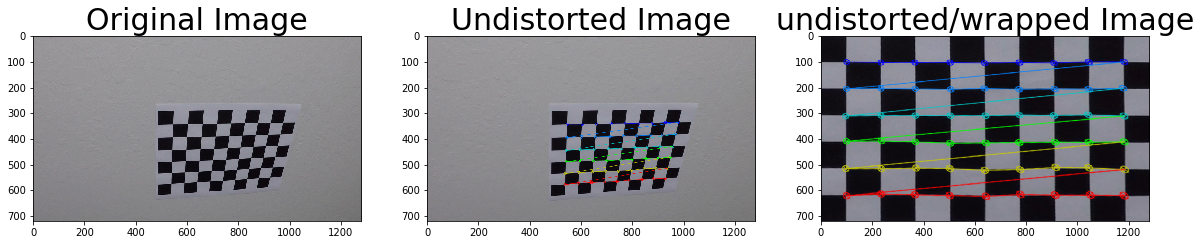

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import glob
%matplotlib inline

#first part of the rubric, chessboard files.


# prepare object points
nx = 9
ny = 6


def calc_objimg_points(images,nx,ny):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints
    
    
def undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def corners_unwarp(img,nx, ny): 
    # function as from the lesson, with small modification
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        img_size = img.shape[1::-1]

        # For source points I'm grabbing the four detected corners, and for
        # dst points in the corners of the image (with 100 offset)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size)
    else: #could not find, so return 
        # a few images don't have all the corners in the picture
        print("could not find corners, so returning orginal image")
        warped=img
        M=None
    # Return the resulting image and matrix
    return warped, M


#load multiple pictures to get distort data
images = glob.glob('camera_cal/*.jpg')
objpoints, imgpoints = calc_objimg_points(images,nx,ny)
image = cv2.imread(images[np.random.randint(len(images)-1)])
#change color is not really needed, kinda b/w anyway
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = undistort(image, objpoints, imgpoints)
unwrapedImage, m =  corners_unwarp(undist,nx, ny)

# Visualize undistortion      
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(unwrapedImage)
ax3.set_title('undistorted/wrapped Image', fontsize=30)

True

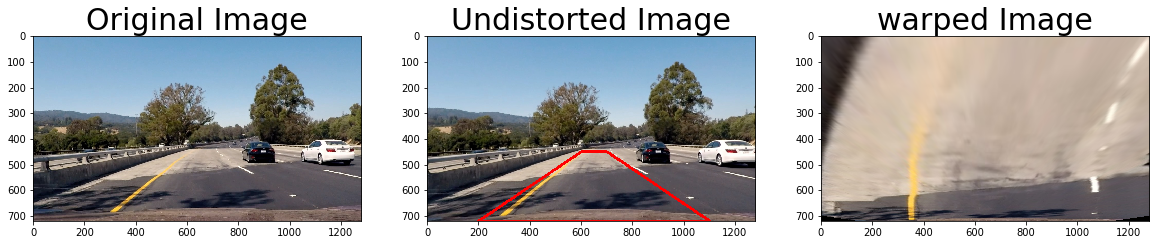

In [2]:
#second part
#Here we read the test image and apply the undist calculated in part 1.
#Then we draw some lines that will be used to wrap it.
def corners_unwarp_road(img,invert=False):
    src=np.float32([[200,720],[594,450],[686,450],[1080,720]])
    dst=np.float32([[300,720],[300,100],[980,100],[980,720]])
    #dst=np.float32([[400,720],[400,100],[880,100],[880,720]])
    if invert:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = img.shape[1::-1]
    warped = cv2.warpPerspective(img, M, img_size)
    return warped
    
#images = glob.glob('test_images/*.jpg')
#images  = cv2.imread(images)#[np.random.randint(len(images)-1)])
#read all files and convert to rgb
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob('test_images/*.jpg')]
imageIndex=np.random.randint(len(images))
undist=np.zeros_like(images)
for i,image in enumerate(images):
    undist[i] = undistort(image, objpoints, imgpoints)



src=np.array([[200,720],[1100,720],[700,450],[600,450]], np.int32)
src = src.reshape((-1,1,2))
undist_line=cv2.polylines(undist[imageIndex].copy(), [src], True,(255,0,0),thickness=10)  
warped=corners_unwarp_road(undist[imageIndex])
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(images[imageIndex])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_line)
cv2.imwrite("undist.jpg",cv2.cvtColor(undist_line, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(warped)
ax3.set_title('warped Image', fontsize=30)
cv2.imwrite("warp.jpg",cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [3]:
# Third part, use images above and apply sobel and some other stuff to
# create a binary image. we use an interact to play around and faster try new threshold values.
# Unfortunatly I don't have so much time left so cant try to many different.
# Another better method would be to use ml to come up with better values.

from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
from ipywidgets import widgets

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
def test(ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max,magthresh_min,
         magthresh_max,dirthresh_min,dirthresh_max,s_thresh_min,s_thresh_max):

    images=undist
    for image in images:
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
        grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))
        mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(magthresh_min, magthresh_max))
        dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(dirthresh_min, dirthresh_max))



        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        gradyx = np.zeros_like(dir_binary)
        gradyx[((gradx == 1) & (grady == 1))] = 1
        magdir = np.zeros_like(dir_binary)
        magdir[(mag_binary == 1) & (dir_binary == 1)] = 1
        combined = np.zeros_like(dir_binary)
        combined[(gradyx ==1 ) | (magdir == 1) | (s_binary == 1)] = 1
        #combined = np.uint8(255*combined/np.max(combined))
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,20))
        gradyx=corners_unwarp_road(gradyx.astype(np.uint8))
        ax1.imshow(gradyx, cmap='gray')
        ax1.set_title('x', fontsize=10)
        
        magdir=corners_unwarp_road(magdir.astype(np.uint8))
        ax2.imshow(magdir, cmap='gray')
        ax2.set_title('y', fontsize=10)
        
        s_binary=corners_unwarp_road(s_binary.astype(np.uint8))
        ax3.imshow(s_binary, cmap='gray')
        ax3.set_title('s', fontsize=10)


        combined=corners_unwarp_road(combined.astype(np.uint8))
        ax4.imshow(combined, cmap='gray')
        ax4.set_title('comb', fontsize=10)

    
    
    #gray = cv2.cvtColor(, cv2.COLOR_RGB2GRAY)#
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    #abs_sobelx = np.absolute(sobelx)
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #thresh_min = 20
    #thresh_max = 255
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray'

interact_manual(test,ksize=widgets.IntSlider(min=1,max=31,step=2,value=9)
    ,xthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,xthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,ythresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,ythresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,magthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,magthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=150)
    ,dirthresh_min=widgets.FloatSlider(min=0,max=np.pi,step=np.pi/20,value=0.7)
    ,dirthresh_max=widgets.FloatSlider(min=0,max=np.pi,step=np.pi/20,value=1.3)
    ,s_thresh_min=widgets.IntSlider(min=1,max=255,step=1,value=80)
    ,s_thresh_max=widgets.IntSlider(min=1,max=255,step=1,value=255))

        #,ksize=widgets.IntSlider(min=1,max=255,step=1,value=1)
        #,ksize=widgets.IntSlider(min=1,max=255,step=1,value=1));
        
def test2(ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max):
    def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # Return the result
        return binary_output
    images=undist[0]
    gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))

    gradyx = np.zeros_like(grady)
    gradyx[((gradx == 1) & (grady == 1))] = 1
    #combined = np.uint8(255*combined/np.max(combined))
    f, (ax1) = plt.subplots(1, 1, figsize=(40,20))
    gradyx=corners_unwarp_road(gradyx.astype(np.uint8))
    ax1.imshow(gradyx, cmap='gray')
    ax1.set_title('x', fontsize=10)
    
interact_manual(test2,ksize=widgets.IntSlider(min=1,max=31,step=2,value=9)
    ,xthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,xthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,ythresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,ythresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230));

#9,30,230,30,230,30,150,0.7,1.3,80,255

interactive(children=(IntSlider(value=9, description='ksize', max=31, min=1, step=2), IntSlider(value=30, description='xthresh_min', max=255, min=1), IntSlider(value=230, description='xthresh_max', max=255, min=1), IntSlider(value=30, description='ythresh_min', max=255, min=1), IntSlider(value=230, description='ythresh_max', max=255, min=1), IntSlider(value=30, description='magthresh_min', max=255, min=1), IntSlider(value=150, description='magthresh_max', max=255, min=1), FloatSlider(value=0.7, description='dirthresh_min', max=3.141592653589793, step=0.15707963267948966), FloatSlider(value=1.3, description='dirthresh_max', max=3.141592653589793, step=0.15707963267948966), IntSlider(value=80, description='s_thresh_min', max=255, min=1), IntSlider(value=255, description='s_thresh_max', max=255, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=9, description='ksize', max=31, min=1, step=2), IntSlider(value=30, description='xthresh_min', max=255, min=1), IntSlider(value=230, description='xthresh_max', max=255, min=1), IntSlider(value=30, description='ythresh_min', max=255, min=1), IntSlider(value=230, description='ythresh_max', max=255, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [4]:
#part 3.5
#basicly same as above but witout interact:
def getBinaryWarp(image,ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max,magthresh_min,
         magthresh_max,dirthresh_min,dirthresh_max,s_thresh_min,s_thresh_max):

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(magthresh_min, magthresh_max))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(dirthresh_min, dirthresh_max))



    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    gradyx = np.zeros_like(dir_binary)
    gradyx[((gradx == 1) & (grady == 1))] = 1
    
    magdir = np.zeros_like(dir_binary)
    magdir[(mag_binary == 1) & (dir_binary == 1)] = 1
    
    combined = np.zeros_like(dir_binary)
    combined[(gradyx ==1 ) | (magdir == 1) | (s_binary == 1)] = 1
    
    return corners_unwarp_road(combined.astype(np.uint8))

In [5]:
#part 4. find the lanes from the binary images
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

#moved this here, maybe change place
ploty = np.linspace(0, images[0].shape[0]-1, images[0].shape[0] )
print(np.shape(ploty))
# Define conversions in x and y from pixels space to meters
ym_per_pix = 40/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension



def laneFinder(image):
    global xm_per_pix
    binary_warped = image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    lane_width=rightx_base-leftx_base
    xm_per_pix = (3.7/lane_width + xm_per_pix)/2 #should be more exact?
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_sum=0
    right_sum=0
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if False:
        # If you found > minpix pixels, recenter next window on their mean position
        
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            if len(good_left_inds) > minpix or len(good_right_inds) > minpix:
                if len(good_left_inds) > 0:
                    left_diff = np.int(np.mean(nonzerox[good_left_inds])) - leftx_current 
                else:
                    left_diff = 0

                if len(good_right_inds) > 0:
                    right_diff =  np.int(np.mean(nonzerox[good_right_inds])) - rightx_current
                else:
                    right_diff = 0

                #right_diff = rightx_current - np.int(np.mean(nonzerox[good_right_inds]))
                lr = len(good_left_inds)/(len(good_right_inds)+len(good_left_inds))
                #print(f"left:{len(good_left_inds)} r: {len(good_right_inds)} lr: {lr}")

                diffs = left_diff*lr + right_diff*(1-lr)
                #print(f"left:{left_diff} right: {right_diff} both: diffs {diffs}")
                leftx_current +=  np.int(diffs)
                rightx_current +=  np.int(diffs)    
                
                


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    tmp=(left_fit[0]+right_fit[0])/2
    left_fit[0]=tmp
    right_fit[0]=tmp
    
    tmp=(left_fit[1]+right_fit[1])/2
    left_fit[1]=tmp
    right_fit[1]=tmp
    
    tmp=(left_fit_cr[0]+right_fit_cr[0])/2
    left_fit_cr[0]=tmp
    right_fit_cr[0]=tmp
    
    tmp=(left_fit_cr[1]+right_fit_cr[1])/2
    left_fit_cr[1]=tmp
    right_fit_cr[1]=tmp
    return left_fit, right_fit, left_fit_cr ,right_fit_cr ,out_img
binary_warped=getBinaryWarp(images[imageIndex],9,30,230,30,230,30,150,0.7,1.3,80,255)
left_fit, right_fit,left_fit_cr ,right_fit_cr , out_img = laneFinder(binary_warped)



(720,)


(720,)
(720,)


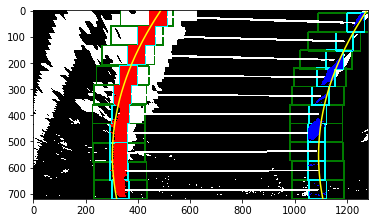

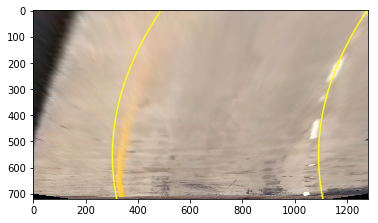

In [6]:
##This is a test thing that don't work so well...

#part 4. find the lanes from the binary images
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

#moved this here, maybe change place
ploty = np.linspace(0, images[0].shape[0]-1, images[0].shape[0] )
print(np.shape(ploty))
# Define conversions in x and y from pixels space to meters
ym_per_pix = 40/720. # meters per pixel in y dimension
xm_per_pix = 3.7/720. # meters per pixel in x dimension



def laneFinder_test(image):
    global xm_per_pix
    
    binary_warped = image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    lane_width=rightx_base-leftx_base
    
    xm_per_pix = (3.7/lane_width + xm_per_pix)/2 #should be more exact?
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_sum=0
    right_sum=0
    
    y_diff=0
    # Step through the windows one by one
    diffLOld=0
    diffROld=0
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #win_y_low = binary_warped.shape[0] - ((window+1)*window_height)
        #win_y_high = binary_warped.shape[0] - (window*window_height)
        win_y_lowL = np.int(binary_warped.shape[0] - ((window+1)*window_height+y_diff))
        win_y_highL = np.int(binary_warped.shape[0] - (window*window_height+y_diff))
        win_y_low = np.int(binary_warped.shape[0] - ((window+1)*window_height-y_diff))
        win_y_high = np.int(binary_warped.shape[0] - (window*window_height-y_diff))
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #print(f"{win_xleft_low},{win_y_lowL},{win_xleft_high},{win_y_highL}")
        cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,123,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,123,0), 5) 
        pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
        pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
        cv2.line(out_img,pt1,pt2,(255,255,255),5)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
        #(nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        #good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        #(nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print(nonzerox[good_right_inds]-win_xright_low)
        #print(nonzerox[good_left_inds]-win_xleft_low)

 
        if len(good_left_inds) > minpix or len(good_right_inds) > minpix:
            
            nonzerox_left=nonzerox[good_right_inds]-win_xright_low
            nonzerox_right=nonzerox[good_left_inds]-win_xleft_low+abs(y_diff)
            nonzerox_tmp=np.concatenate((nonzerox_left,nonzerox_right))
            bins=np.bincount(nonzerox_tmp)
            best_index=np.argmax(bins)-margin
            mean_index=np.mean(nonzerox_tmp)-margin
            right_diff = left_diff = (best_index+mean_index)//2
            y_diff=np.int((right_diff+left_diff+y_diff)//8)
            diffROld=right_diff*.5+diffROld*0.5
            diffLOld=left_diff*.5+diffLOld*0.5
        leftx_current +=  np.int(diffLOld)#np.int(diffs)
        rightx_current += np.int(diffROld) #np.int(diffs)
        
        win_xleft_low = leftx_current - margin//3
        win_xleft_high = leftx_current + margin//3
        win_xright_low = rightx_current - margin//3
        win_xright_high = rightx_current + margin//3
        
        good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            
        cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,255,255), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 5) 
        pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
        pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
        cv2.line(out_img,pt1,pt2,(255,255,255),5)
      
            
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)   
   
                
    
    


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    
    #ploty = np.linspace(0, 719, num=720)
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    
    tmp=(left_fit[0]+right_fit[0])/2
    left_fit[0]=tmp
    right_fit[0]=tmp
    
    tmp=(left_fit[1]+right_fit[1])/2
    left_fit[1]=tmp
    right_fit[1]=tmp
    
    tmp=(left_fit_cr[0]+right_fit_cr[0])/2
    left_fit_cr[0]=tmp
    right_fit_cr[0]=tmp
    
    tmp=(left_fit_cr[1]+right_fit_cr[1])/2
    left_fit_cr[1]=tmp
    right_fit_cr[1]=tmp
    return left_fit, right_fit, left_fit_cr ,right_fit_cr ,out_img

plt.imshow(out_img)
imageIndex=np.random.randint(len(images))
binary_warped=getBinaryWarp(images[imageIndex],9,30,230,30,230,30,150,0.7,1.3,80,255)
left_fit, right_fit,left_fit_cr ,right_fit_cr , out_img = laneFinder_test(binary_warped)

#print(left_fit)
#print(right_fit)

#both lines should be parrallel from above,
#also, diff in [2] should be about the same for all images (dist between lanes),
#so can use some sane filter using this.
#tmp=(left_fit[0]+right_fit[0])/2
#left_fit[0]=tmp
#right_fit[0]=tmp
#tmp=(left_fit[1]+right_fit[1])/2
#left_fit[1]=tmp
#right_fit[1]=tmp
plt.imshow(out_img)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
print(np.shape(ploty))
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]




plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)
plt.show()
plt.imshow(corners_unwarp_road(images[imageIndex]))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

In [7]:
#Add filled area to the image,
def addFilledArea(image,left_fitx,right_fitx,ploty):
    filled_area=np.zeros_like(image).astype(np.uint8)
    fitx_both=np.concatenate((np.transpose([left_fitx,ploty]),np.transpose([right_fitx[::-1],ploty[::-1]])))
    cv2.fillPoly(filled_area,np.int_([fitx_both]),(0,255,0))
    filled_area_unwarp = corners_unwarp_road(filled_area,True)
    return cv2.addWeighted(filled_area_unwarp,1,image,0.8,0)

#Add text to the image
def addText(image,center_dist,left_curverad,right_curverad):
    cv2.putText(image, f"Curve Left: {left_curverad}",(50,100),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    cv2.putText(image, f"Curve Right: {right_curverad}",(50,150),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    cv2.putText(image, f"Center Distance: {center_dist}",(50,200),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    return image

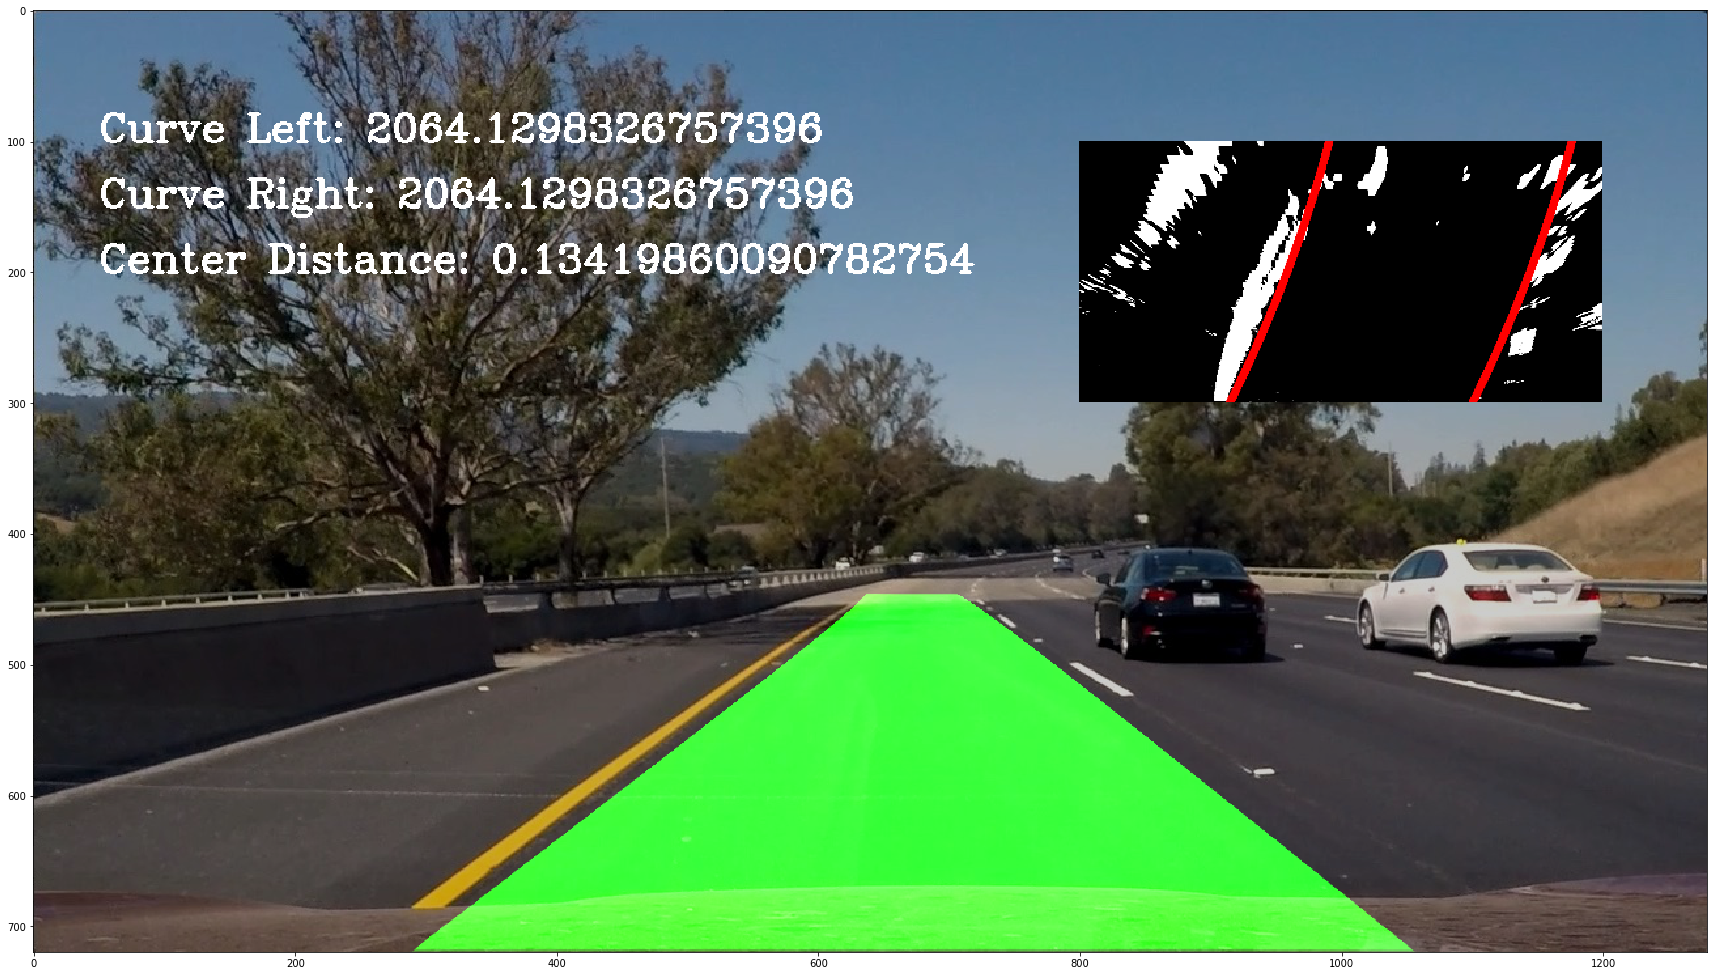

In [8]:
## Main pipline
# There's probably better ways so we can use variables as 
# arguments instead of globals
def process_image(input_image):
    image = undistort(input_image, objpoints, imgpoints)
    image = getBinaryWarp(image,9,30,230,30,230,30,150,0.7,1.3,110,255)
    left_fit, right_fit,left_fit_cr ,right_fit_cr, out_img = laneFinder(image) 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    result_image = addFilledArea(input_image,left_fitx,right_fitx,ploty)
    
    y_eval = np.max(ploty)
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1] )**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center_dist=(left_fitx[-1]+right_fitx[-1])*xm_per_pix/2 - (out_img.shape[1]*xm_per_pix)/2 

    #add binarry in corner, good to evaluate if it works well
    #https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
    
    x_offset=800
    y_offset=100
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    binary_image=image.copy()
    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)*255 
    pts=np.int32(np.transpose(np.array([left_fitx,ploty])))
    pts2=np.int32(np.transpose(np.array([right_fitx,ploty])))
    binary_image=cv2.polylines(binary_image,[pts],False,(255,0,0),20)
    binary_image=cv2.polylines(binary_image,[pts2],False,(255,0,0),20)
    binary_image = cv2.resize(binary_image, (400,200))
    result_image = addText(result_image,center_dist,left_curverad,right_curverad)
    result_image[y_offset:y_offset+200, x_offset:x_offset+400] = binary_image
    return result_image


#To try above with an image:
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob('test_images/*.jpg')]
imageIndex=np.random.randint(len(images)-1)
plt.figure(figsize = (30,30)) 
plt.imshow(process_image(images[imageIndex]))



In [9]:
#main part
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'test_videos_output/project_video2.mp4'

video_input = VideoFileClip("project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
video = video_input.fl_image(process_image) #NOTE: this function expects color images!!
%time video.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 150/150 [03:05<00:00,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 3min 8s, sys: 596 ms, total: 3min 9s
Wall time: 3min 8s
